In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, auc, RocCurveDisplay, roc_curve, confusion_matrix
sys.path.append("..")
from src import *

2024-06-25 11:11:32.060058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 11:11:32.104172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 11:11:32.930887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"
config_path = "/data/bionets/je30bery/melanoma_data/config.json" if "ramses" in os.uname()[1] else "/data_nfs/je30bery/melanoma_data/config.json"

In [4]:
data = get_data_csv(groups=["Melanoma", "Nevus"], high_quality_only=False, pfs=True, config_path=config_path)
data = data.reset_index().drop("index", axis=1)

In [5]:
with open(config_path, "r") as f:
    configs = json.load(f)
    dataset_statistics = configs["dataset_statistics"]
    checkpoint_path = configs["model_weights"]
    pretrained_model = configs["pretrained_model_path"]

with open(os.path.join(dataset_statistics, f'melanoma_means.json'), 'r') as fp:
    means = json.load(fp)
    markers = list(means.keys())

In [6]:
splits = {
    0: ['B513'],
    1: ['B279'],
    2: ['B484'],
    3: ['B033', 'B032', 'B031', 'B029', 'B030'],
    4: ['B104'],
    5: ['B148'],
    6: ['B196'],
    7: ['B407'],
    8: ['B217'],
    9: ['B515'],
    10: ['B023'],
    11: ['B168'],
    12: ['B345'],
    13: ['B397'],
    14: ['B096'],
    15: ['B502', 'B503'],
    16: ['B390'],
    17: ['B218'],
    18: ['B488', 'B487'],
    19: ['B274'],
    20: ['B462'],
    21: ['B497']
}

In [7]:
model = ResNet18_smoothgrad(indim=len(markers), cam=True, checkpoint_path=checkpoint_path)
model = model.to("cuda:0")
finetuned_models_path = "../src/model/final_finetuned_models/"
finetuned_models = os.listdir(finetuned_models_path)
subsets = list()
data["Prediction"] = 0

for split in tqdm(splits):
    data_subset = data[data["Histo-ID"].isin(splits[split])]
    if len(data_subset) == 0:
        continue
    dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=False, data=data_subset, mode="val", config_path=config_path), batch_size=1, shuffle=False)
    model_path = [m for m in finetuned_models if f"split={split}" in m][0]
    model.load_state_dict(t.load(os.path.join(finetuned_models_path, model_path), map_location="cuda:0"), strict=True)
    model.eval()
    it = iter(dl)
    preds = list()
    for i in range(len(data_subset)):
        x, y, _ = next(it)
        y_pred = model(x.cuda()).detach().cpu().numpy().item()
        preds.append(y_pred)     
    data.loc[data["Histo-ID"].isin(splits[split]), "Prediction"] = preds

100%|█████████████████████████████████████████████████████████████| 22/22 [03:44<00:00, 10.20s/it]


In [21]:
accs = list()
labels = list()
preds = list()
for split in tqdm(splits):
    for histo_id in splits[split]:
        data_subset = data[data["Histo-ID"] == histo_id]
        label = data_subset["PFS label"]
        labels.append(np.unique(label)[0])
        pred = data_subset["Prediction"]
        accs.append(accuracy_score(y_true=label, y_pred=pred > 0.48))
accs = np.array(accs)
labels = np.array(labels)

100%|████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 676.76it/s]


In [22]:
print(len(accs), np.mean(accs))
print(np.sum(labels==0), np.mean(accs[np.where(labels==0)]))
print(np.sum(labels==1), np.mean(accs[np.where(labels==1)]))
print()

28 0.8678571428571429
20 0.865
8 0.875



In [23]:
accs = list()
labels = list()
preds = list()
for split in tqdm(splits):
    for histo_id in splits[split]:
        data_subset = data[data["Histo-ID"] == histo_id]
        label = np.unique(data_subset["PFS label"])[0]
        labels.append(label)
        preds.append(np.mean(data_subset["Prediction"]))

100%|███████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1796.70it/s]


In [24]:
len(preds)

28

In [40]:
binary_preds = np.array(preds) >= 0.5
labels = np.array(labels)

print(confusion_matrix(y_true=labels, y_pred=binary_preds))
print(accuracy_score(y_true=labels, y_pred=binary_preds))
print_metrics(y_true=labels, y_pred=binary_preds)
print(roc_auc_score(y_true=labels, y_score=preds))

[[18  2]
 [ 1  7]]
0.8928571428571429
Accuracy 0.8928571428571429
F1 0.823529411764706
AUC-ROC 0.8875
Recall 0.875
Precision 0.7777777777777778
Accuracy in negative class 0.9
Accuracy in positive class 0.875
Sensitivity (Recall): 0.875
Specificity: 0.9
0.9875


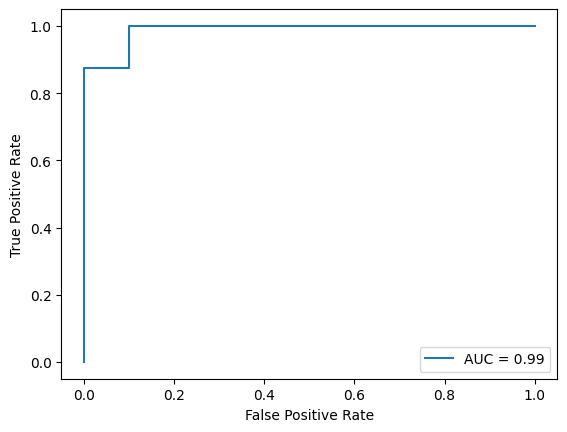

In [27]:
#fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)  # Adjust the figsize as needed

#y = data["PFS label"]
#pred = data["Prediction"]
#fpr, tpr, thresholds = roc_curve(y, pred)
#roc_auc = auc(fpr, tpr)
#display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
#display.plot(ax=axs[0])

fpr, tpr, thresholds = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot() #ax=axs[1]
plt.show()
#plt.savefig("PFS_prediction_AUC.pdf", bbox_inches="tight")